In [61]:
%matplotlib inline

import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import scipy.stats as ss
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

import Notebook_Loader # Allows for importing Jupyter Notebooks
import Feature_Vectors as fVec

##### Functions

def loadAudioCalcSTFT(queryfile): #add in sample rate, hop size, window size stuff later
    y, sr = lb.core.load(queryfile)
    S = lb.core.stft(y)
    Smag = np.abs(S)
    return y, sr, S, Smag

def obtainObservations(audio, sr = 22050):
    #get beat locations (in samples), backtracked
    beats = lb.onset.onset_detect(audio, sr=sr, units='samples', backtrack=True) #currently the backtracking is not very good
    beats = np.delete(beats,0) # first estimate is usually wrong, check this tho
    numObsv = beats.shape[0]
    print(beats)
    
    #get tempo
    tempo_bpm = lb.beat.tempo(audio, sr=sr)
    tempo_bpm = int(round(tempo_bpm[0]))
    print("Tempo in bpm: ", tempo_bpm)
    
    #determine eighth measure window size in samples
    tempo_bps = tempo_bpm/60.0
    quarterMeasure = 1/tempo_bps #time period for 1 beat, i.e. a quarter measure
    eighthMeasure = quarterMeasure/2
    print(eighthMeasure)
    win_size = int(round(eighthMeasure*sr)) #get window size in samples
    print(win_size)
    
    #observations array
    obsvArray = np.zeros((win_size, numObsv))
    for i in range(numObsv):
        onset = beats[i]
        obsvArray[:,i] = audio[onset:onset+win_size]
    
    return tempo_bpm, obsvArray

def calcFeatures(obsv): 
    '''single obsv: a 1D array representing samples over an eighth measure containing a percussion sound
       returns a feature vector'''
    F = np.zeros(8)
    stft = np.abs(lb.core.stft(obsv))
    env = fVec.envelope(obsv)
    
    #calculate feature parameters
    maxInd = np.argmax(stft) # Linear/Flattened Index
    maxInds = np.unravel_index(maxInd, stft.shape)
    attack, decay, sustain, release = fVec.calcADSR(obsv, env)
    
    F[0] = np.average(obsv) # May or may not keep
    F[1] = maxInds[0] # Frequency (DFT index)
    F[2] = maxInds[1] # Time (in frames)
    F[3] = np.max(stft)   
    F[4] = attack
    F[5] = decay
    F[6] = sustain
    F[7] = release
    
    return F

##### Main script

In [62]:
## top-level 
#  Use this to set queryfile from data
queryfile = 'audio_data/rsalazar_rec7.wav'
ipd.Audio(queryfile)

In [63]:
audio, sr, S, Smag = loadAudioCalcSTFT(queryfile) #get audio and STFT
tempo, obsvArray = obtainObservations(audio) #get observations

#model = makeModel('audio_data/rsalazar_rec3.wav')

[ 66560  70656  76288  81408  83456  88064  94720 104960 109056 112640
 119808 124416 133632 144896 148480 153600 157184 160256 169472 181760
 185856 190976 195072 199680 208384]
Tempo in bpm:  136
0.22058823529411764
4864


Number of observations:  25


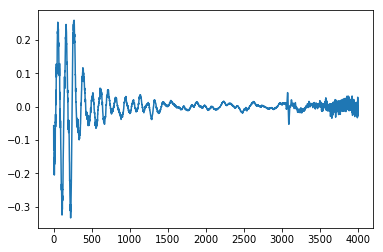

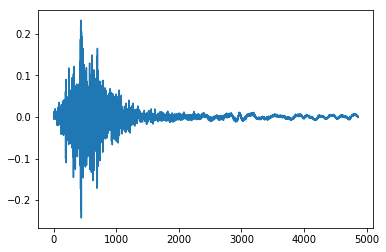

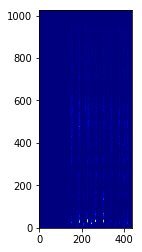

In [67]:
#visualization, playing around with data
print("Number of observations: ", obsvArray.shape[1])
plt.figure(1)
plt.plot(audio[86000:90000])
plt.show()

obsv_idx = 10
plt.figure(2)
plt.plot(obsvArray[:,obsv_idx])
plt.show()

plt.figure(3)
plt.imshow(Smag, origin = 'lower', cmap = 'jet')